## Predicting House Sale Prices

### Introduction
In this project we'll be working with housing data for the city Ames, Iowa fro, 2006 to 2010. You can download the data set from [Kaggle](https://www.kaggle.com/hamzajabbarkhan/ames-housingtsv).

We'll be practicing in linear regression modeling.

Let's start from importing all necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

And now take a look at the data set.

In [2]:
housing_df = pd.read_csv('AmesHousing.tsv', delimiter='\t')
print(housing_df.shape)
housing_df.head()

(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


More info about columns you can find [here](https://s3.amazonaws.com/dq-content/307/data_description.txt)

### Builidng functions

We'll set up a pipeline that will let us easily iterate on future models. We'll create several functions for that according image below.
![Image](https://s3.amazonaws.com/dq-content/240/pipeline.svg)

Each function will be stored in different cells.

In [3]:
def transform_features(df):
    '''
    Func creates traing and test data sets
    
    df - whole original data set
    '''
    train_len = round(0.75 * df.shape[0])
    
    train_set = df[:train_len]
    test_set = df[train_len:]
    
    return train_set, test_set

In [4]:
def select_features(df):
    '''
    Func returns feature columns from the data set
    
    df - whole original data set    
    '''
    features_df = df[['Gr Liv Area', 'SalePrice']]
    
    return features_df

In [5]:
def train_and_test(df):
    '''
    Func train and test linear regression model on df.
    It returns RMSE
    
    df - whole original data set    
    '''
    train_set, test_set = transform_features(df)
    
    #Take all numeric columns except target from df returned from select_features()
    training = select_features(train_set).drop('SalePrice', axis=1).columns
    
    target = 'SalePrice'
    
    lin_reg = LinearRegression().fit(train_set[training],
                                      train_set[target])
    
    predictions = lin_reg.predict(test_set[training])
    
    rmse = mean_squared_error(test_set[target], predictions, squared=False)
    
    return rmse

We've used only `Gr Liv Area` columns as feature for the first time. Here is the result.

In [6]:
train_and_test(housing_df)

52356.708196342326

### Feature engineering

Let's start improving our model. First of all we'll take care of missing values.

We'll simply delete any columns that have more than **30%** of missing values.

In [7]:
missing_values_count = housing_df.isnull().sum()

cols_to_drop = missing_values_count[missing_values_count > 0.3*housing_df.shape[0]].index
print(cols_to_drop)

cleaned_housing_df = housing_df.drop(cols_to_drop, axis=1)

Index(['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')


Any numeric columns that have less than **5%** of missing values we'll fill with mode.

In [8]:
cleaned_housing_df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   Lot Frontage     2440 non-null   float64
 4   Lot Area         2930 non-null   int64  
 5   Overall Qual     2930 non-null   int64  
 6   Overall Cond     2930 non-null   int64  
 7   Year Built       2930 non-null   int64  
 8   Year Remod/Add   2930 non-null   int64  
 9   Mas Vnr Area     2907 non-null   float64
 10  BsmtFin SF 1     2929 non-null   float64
 11  BsmtFin SF 2     2929 non-null   float64
 12  Bsmt Unf SF      2929 non-null   float64
 13  Total Bsmt SF    2929 non-null   float64
 14  1st Flr SF       2930 non-null   int64  
 15  2nd Flr SF       2930 non-null   int64  
 16  Low Qual Fin SF  2930 non-null   int64  
 17  Gr Liv Area   

In [34]:
missing_numeric = cleaned_housing_df.select_dtypes(
            'number').isnull().sum()

cols_to_fill = missing_numeric[(missing_numeric < 0.05*housing_df.shape[0]
                               ) & (missing_numeric != 0)].index
print(cols_to_fill)

modes = cleaned_housing_df[cols_to_fill].mode()

cleaned_housing_df[cols_to_fill] = cleaned_housing_df[
    cols_to_fill].fillna(value=modes)

Index(['Mas Vnr Area', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Garage Cars', 'Garage Area'],
      dtype='object')


In [35]:
cleaned_housing_df[
    cols_to_fill].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mas Vnr Area    2907 non-null   float64
 1   Total Bsmt SF   2929 non-null   float64
 2   Bsmt Full Bath  2928 non-null   float64
 3   Bsmt Half Bath  2928 non-null   float64
 4   Garage Cars     2929 non-null   float64
 5   Garage Area     2929 non-null   float64
dtypes: float64(6)
memory usage: 137.5 KB


In [32]:
cleaned_housing_df[cols_to_fill].mode()

,Mas Vnr Area,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Cars,Garage Area
0,0.0,0.0,0.0,0.0,2.0,0.0


In [28]:
cleaned_housing_df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2930 non-null   int64  
 1   Lot Frontage       2440 non-null   float64
 2   Lot Area           2930 non-null   int64  
 3   Overall Qual       2930 non-null   int64  
 4   Overall Cond       2930 non-null   int64  
 5   Mas Vnr Area       2907 non-null   float64
 6   Total Bsmt SF      2929 non-null   float64
 7   1st Flr SF         2930 non-null   int64  
 8   2nd Flr SF         2930 non-null   int64  
 9   Low Qual Fin SF    2930 non-null   int64  
 10  Gr Liv Area        2930 non-null   int64  
 11  Bsmt Full Bath     2928 non-null   float64
 12  Bsmt Half Bath     2928 non-null   float64
 13  Full Bath          2930 non-null   int64  
 14  Half Bath          2930 non-null   int64  
 15  Bedroom AbvGr      2930 non-null   int64  
 16  Kitchen AbvGr      2930 

In [26]:
cleaned_housing_df['Garage Area'].value_counts()

0.0       157
576.0      97
440.0      96
484.0      76
240.0      69
         ... 
208.0       1
815.0       1
1043.0      1
1184.0      1
428.0       1
Name: Garage Area, Length: 603, dtype: int64

Now we'll create our ownn features like `house_age` and `years_until_remod`.

In [11]:
cleaned_housing_df['house_age'] = cleaned_housing_df[
    'Yr Sold'] - cleaned_housing_df['Year Built']

cleaned_housing_df['years_until_remod'] = cleaned_housing_df[
    'Yr Sold'] - cleaned_housing_df['Year Remod/Add']

And then we'll delete columns which we used above. Also delete some useless columns like `Mo Sold` and a few columns about particular areas in the basement. We'll keep only `Total Bsmt SF`.

In [12]:
useless_cols = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                'Garage Yr Blt', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF']

cleaned_housing_df = cleaned_housing_df.drop(useless_cols, axis=1)

Let's take a look at the correlations between feature columns aswell.

In [13]:
cleaned_housing_df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2930 non-null   int64  
 1   Lot Frontage       2440 non-null   float64
 2   Lot Area           2930 non-null   int64  
 3   Overall Qual       2930 non-null   int64  
 4   Overall Cond       2930 non-null   int64  
 5   Mas Vnr Area       2907 non-null   float64
 6   Total Bsmt SF      2929 non-null   float64
 7   1st Flr SF         2930 non-null   int64  
 8   2nd Flr SF         2930 non-null   int64  
 9   Low Qual Fin SF    2930 non-null   int64  
 10  Gr Liv Area        2930 non-null   int64  
 11  Bsmt Full Bath     2928 non-null   float64
 12  Bsmt Half Bath     2928 non-null   float64
 13  Full Bath          2930 non-null   int64  
 14  Half Bath          2930 non-null   int64  
 15  Bedroom AbvGr      2930 non-null   int64  
 16  Kitchen AbvGr      2930 

<AxesSubplot:>

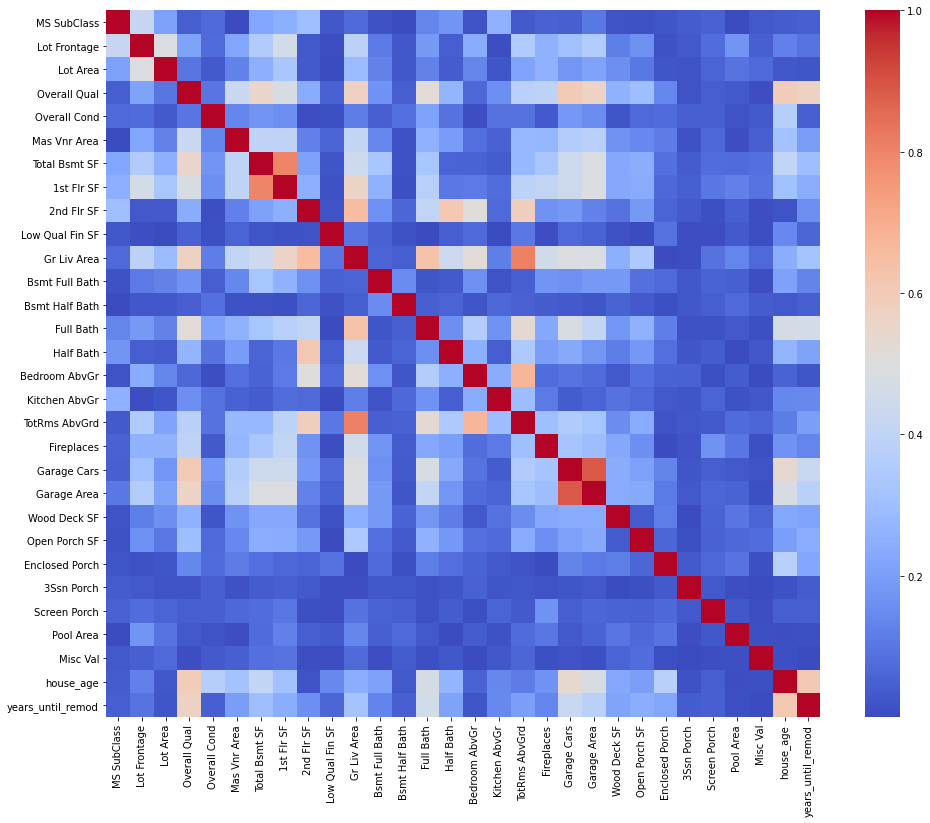

In [14]:
feature_corrs = cleaned_housing_df.drop('SalePrice', axis=1).corr().abs()

fig, ax = plt.subplots(figsize=(16,13))
sns.heatmap(feature_corrs, cmap='coolwarm')

In [15]:
feature_corrs[feature_corrs.abs() >= 0.4]

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,house_age,years_until_remod
MS SubClass,1.000000,0.420135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lot Frontage,0.420135,1.000000,0.491313,NaN,NaN,NaN,NaN,0.457391,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lot Area,NaN,0.491313,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall Qual,NaN,NaN,NaN,1.000000,NaN,0.429418,0.547294,0.477837,NaN,NaN,...,0.563503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.597021,0.570956
Overall Cond,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mas Vnr Area,NaN,NaN,NaN,0.429418,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Bsmt SF,NaN,NaN,NaN,0.547294,NaN,NaN,1.000000,0.800720,NaN,NaN,...,0.485504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.407360,NaN
1st Flr SF,NaN,0.457391,NaN,0.477837,NaN,NaN,0.800720,1.000000,NaN,NaN,...,0.491223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Flr SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Low Qual Fin SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
cleaned_housing_df['Total Bsmt SF'].value_counts()

0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
1603.0     1
5095.0     1
839.0      1
2630.0     1
1570.0     1
Name: Total Bsmt SF, Length: 1058, dtype: int64

In [17]:
cleaned_housing_df[['MS SubClass', 'Lot Area', 'Bsmt Full Bath',
                   'Total Bsmt SF','1st Flr SF']].corr()

,MS SubClass,Lot Area,Bsmt Full Bath,Total Bsmt SF,1st Flr SF
MS SubClass,1.000000,-0.204613,0.013701,-0.219445,-0.247828
Lot Area,-0.204613,1.000000,0.125877,0.253589,0.332235
Bsmt Full Bath,0.013701,0.125877,1.000000,0.326232,0.261700
Total Bsmt SF,-0.219445,0.253589,0.326232,1.000000,0.800720
1st Flr SF,-0.247828,0.332235,0.261700,0.800720,1.000000


In [18]:
cleaned_housing_df[['Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch']].corr()

,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch
Open Porch SF,1.000000,-0.059875,-0.009458,0.047548
Enclosed Porch,-0.059875,1.000000,-0.032674,-0.063965
3Ssn Porch,-0.009458,-0.032674,1.000000,-0.029430
Screen Porch,0.047548,-0.063965,-0.029430,1.000000


In [19]:
def transform_features(df):
    '''
    
    Then func creates traing and test data sets
    
    df - whole original data set
    '''
    
    #Delete rows with more than 30% of NaN
    missing_values_count = df.isnull().sum()
    cols_to_drop = missing_values_count[
        missing_values_count > 0.3*df.shape[0]].index
    
    cleaned_df = df.drop(cols_to_drop, axis=1)
    
    #Fill NaNs with modes in the numeric columns
    missing_numeric = cleaned_df.select_dtypes(
                                    'number').isnull().sum()

    cols_to_fill = missing_numeric[(missing_numeric < 0.05*df.shape[0]
                                  ) & (missing_numeric != 0)].index
    
    cleaned_df[cols_to_fill] = cleaned_df[
                    cols_to_fill].fillna(cleaned_df[cols_to_fill].mode())
    
    #Create new features
    cleaned_df['house_age'] = cleaned_df[
                        'Yr Sold'] - cleaned_df['Year Built']

    cleaned_df['years_until_remod'] = cleaned_df[
                            'Yr Sold'] - cleaned_df['Year Remod/Add']
    
    #Columns list that uselees for model
    useless_cols = ['Order', 'PID', 'Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add',
                'Garage Yr Blt', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF']

    cleaned_df = cleaned_df.drop(useless_cols, axis=1)
    
    train_len = round(0.75 * cleaned_df.shape[0])
    
    train_set = cleaned_df[:train_len]
    test_set = cleaned_df[train_len:]
    
    return train_set, test_set

In [20]:
def select_features(df):
    '''
    Func returns feature numeric columns from the data set
    
    df - whole original data set    
    '''
    features_df = df.select_dtypes(include='number')
    
    features_df = features_df.notnull().all()
    
    return features_df

In [21]:
xxx = housing_df.select_dtypes(include='number').notnull().all()
xxx

Order               True
PID                 True
MS SubClass         True
Lot Frontage       False
Lot Area            True
Overall Qual        True
Overall Cond        True
Year Built          True
Year Remod/Add      True
Mas Vnr Area       False
BsmtFin SF 1       False
BsmtFin SF 2       False
Bsmt Unf SF        False
Total Bsmt SF      False
1st Flr SF          True
2nd Flr SF          True
Low Qual Fin SF     True
Gr Liv Area         True
Bsmt Full Bath     False
Bsmt Half Bath     False
Full Bath           True
Half Bath           True
Bedroom AbvGr       True
Kitchen AbvGr       True
TotRms AbvGrd       True
Fireplaces          True
Garage Yr Blt      False
Garage Cars        False
Garage Area        False
Wood Deck SF        True
Open Porch SF       True
Enclosed Porch      True
3Ssn Porch          True
Screen Porch        True
Pool Area           True
Misc Val            True
Mo Sold             True
Yr Sold             True
SalePrice           True
dtype: bool

In [22]:
train_and_test(housing_df)

ValueError: No axis named 1 for object type Series